Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *



***
## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [3]:
df_voles = pd.read_csv("http://bit.ly/2IgDF0E")

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [4]:
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


***
## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

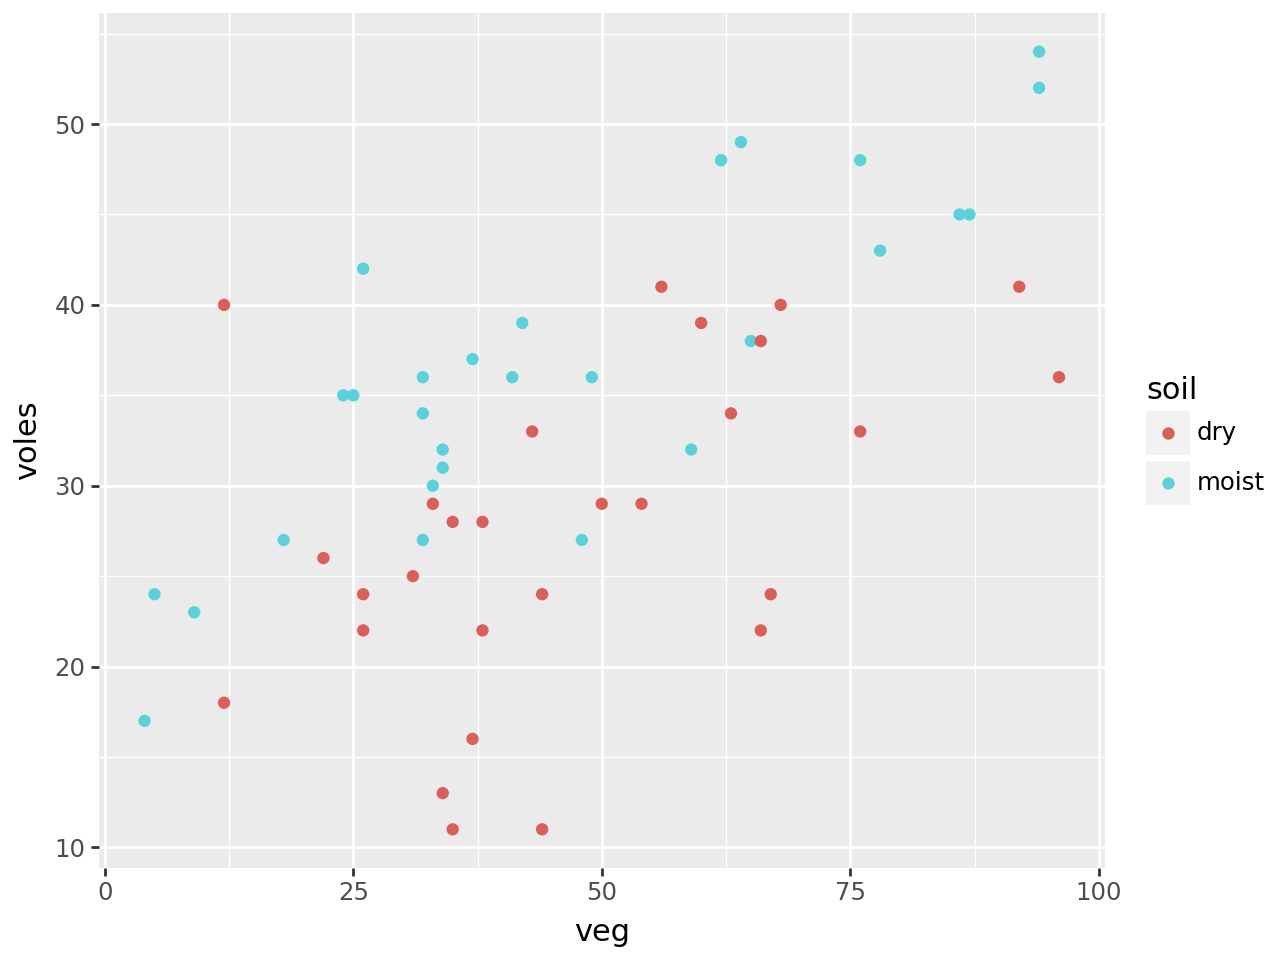

In [14]:

(
    ggplot(df_voles)
    + aes(x='veg',y='voles', color='soil')
    + geom_point()
)



***
## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [27]:
# first make the column transformer
column_transformer = make_column_transformer(
    [OneHotEncoder(drop="first"), ['soil']],
    ['passthrough', ['veg']]
)

# create the pipeline
pipeline = make_pipeline(column_transformer, LinearRegression())

# get the X and y
X = df_voles[['soil', 'veg']]
y = df_voles['voles']

# fit the model
pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil']),
                                                 ('passthrough', 'passthrough',
                                                  ['veg'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [28]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [29]:
get_regression_table(pipeline)

,term,estimate
0,onehotencoder__soil_moist,9.100298
1,passthrough__veg,0.259069
2,intercept,15.464026


In [36]:
df_voles = df_voles.assign(pred_voles=pipeline.predict(X))
#df_voles.assign(pred_voles=lambda df_: pipeline.predict(df_))

df_voles.head()

,site,voles,veg,soil,pred_voles
0,1,17,4,moist,25.600600
1,2,30,33,moist,33.113599
2,3,54,94,moist,48.916804
3,4,49,64,moist,41.144736
4,5,34,32,moist,32.854530


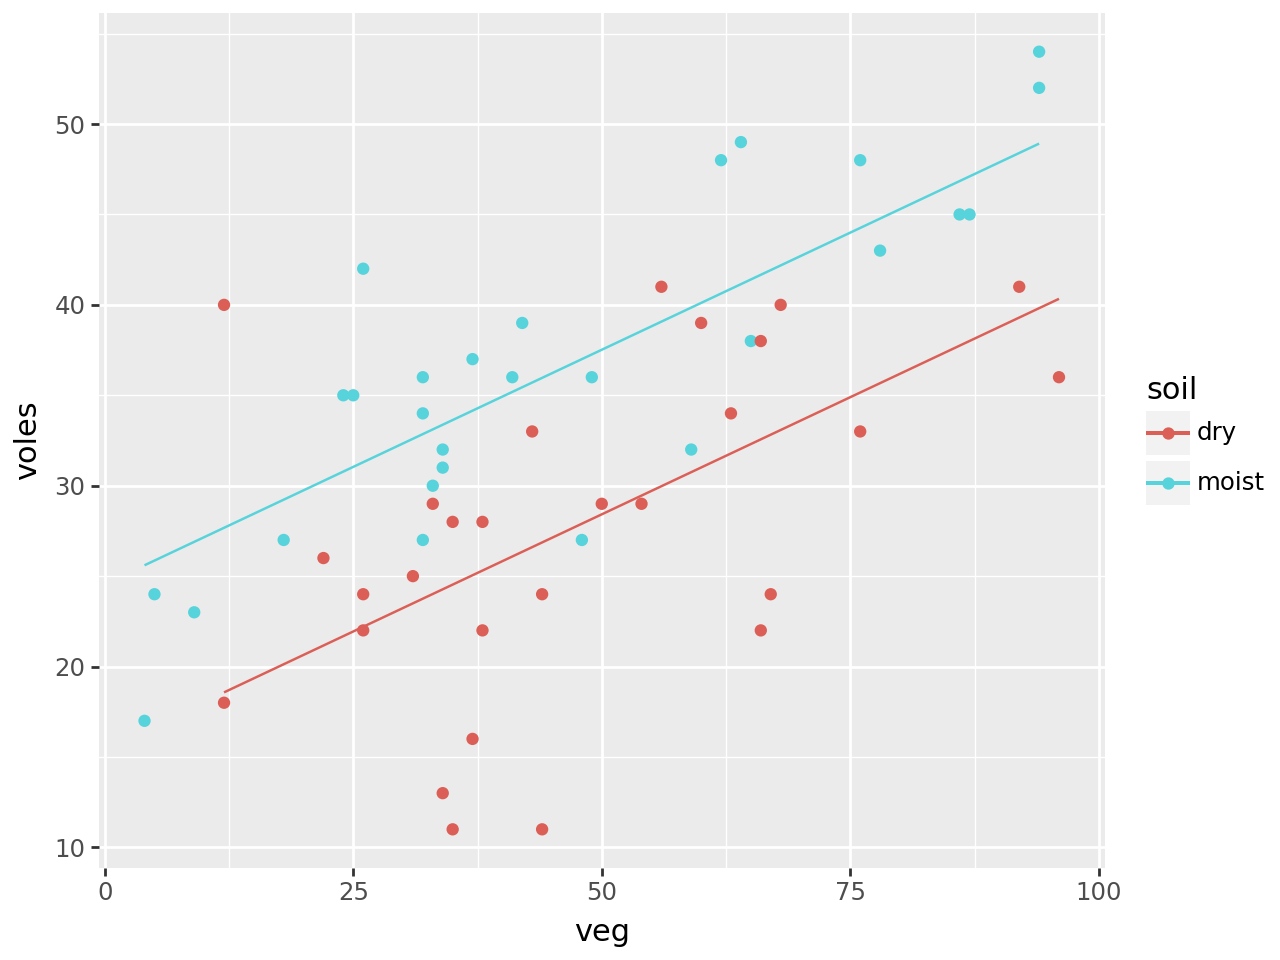

In [37]:
(
    ggplot(df_voles)
    + aes(x='veg',y='voles', color='soil')
    + geom_point()
    + geom_line(aes(x='veg',y='pred_voles'))
)

❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

It depends on what you determine to be the best method to preserve a population. For example, some questions that should be asked first:
- Which is more important? Population density or number of habitats?
- What is considered high vegetation? 50%?
- What is the cost to benefit ratio of maintaining the different types of habitats? 

Generally speaking, you can maintain a high level of population at a relatively low vegetation 25% - 50% where there seems to be the highest density of vole habitats recorded in this data. Whether the soil is dry or wet will determine if you're preserving 30 or 40 voles per habitat. 

However, I would say, you can maintain the vole population regardless of vegetation, I think it comes down to a question of would you rather support 2-3 habitats with 90% vegetation supporting ~60+ voles each or 5-6 habitats with 50% vegetation and ~40+ voles each? Which one costs more to maintain? 

***
❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

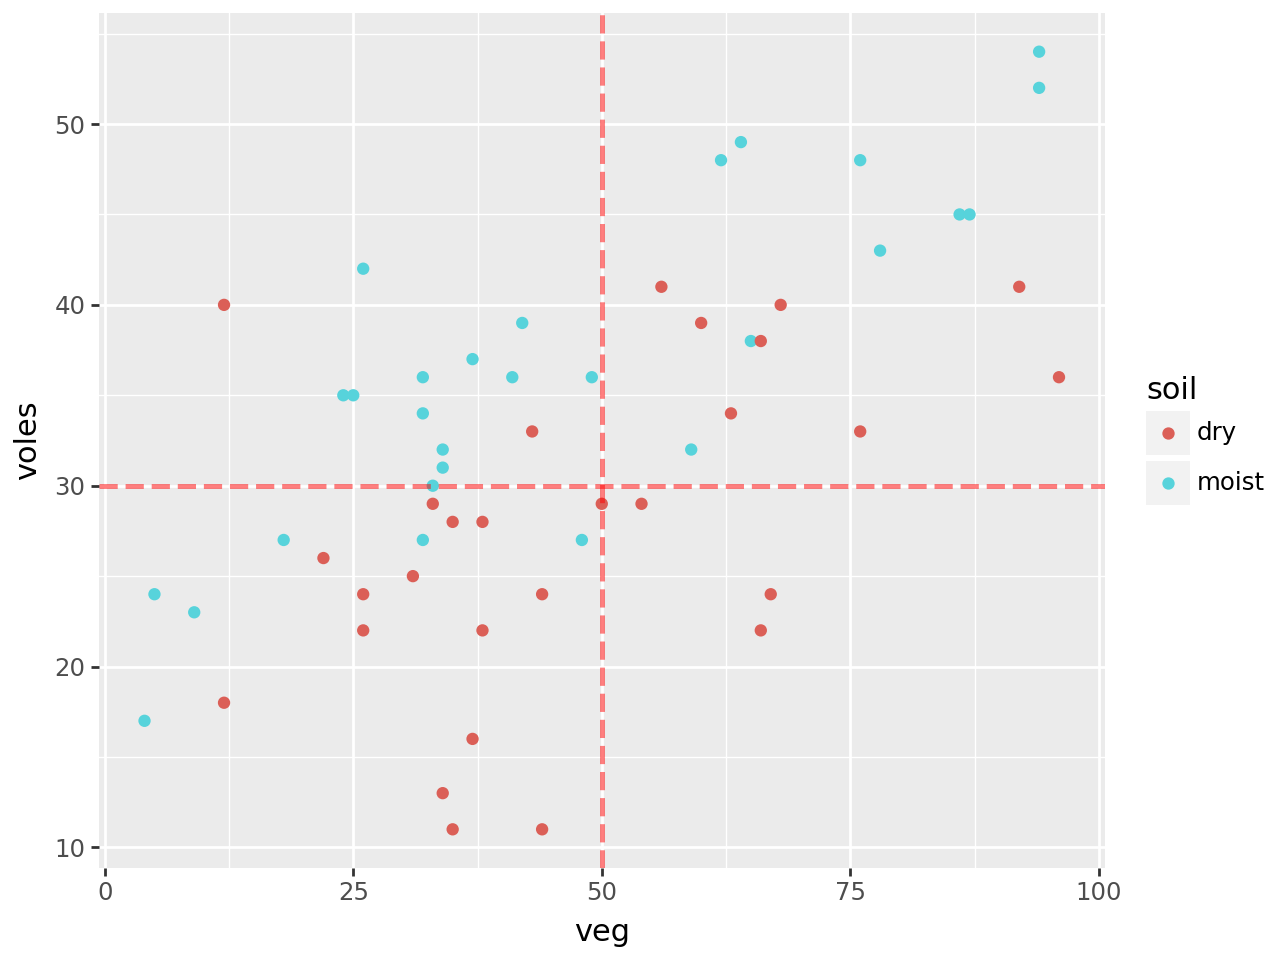

In [23]:
(
    ggplot(df_voles)
    + aes(x='veg',y='voles', color='soil')
    + geom_point()
    + geom_hline(yintercept=30, color='red', linetype='dashed', size=1, alpha=0.5)
    + geom_vline(xintercept=50, color='red', linetype='dashed', size=1, alpha=0.5)
)

Frankly, a dry conservation isn't good for supporting a population of voles (>30). You need a vegetation coverage of roughly 53% ~ 55% to support that large of a population.

***
❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with your pipeline.)

**Answer:**

In [38]:
pipeline.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))

array([34.92708151])

The regressional predicts that it would be able to support somewhere around 34-35 voles, which looking at the graph and cluster for moist, that would make sense. 